In [1]:
dnn_attack_intensity = 5

In [2]:
from models.ae import AE
from models.vae import VAE
from models.rnn import RNN
from models.dnn import DNN
from models.dnnAE import DNN as DNNAE


import torch
import torch.nn.functional as F

from sklearn import metrics

import re
import os
import numpy as np
from tqdm import tqdm
from scipy.io import loadmat
import matplotlib.pyplot as plt
from collections import defaultdict
from pandas import DataFrame, concat

In [3]:
seed = 17
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Path to all dataset
DATASET_PATH = os.path.join(os.getcwd(), 'data')
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.path.join(os.getcwd(), 'checkpoints')

In [5]:
# vae parameter
latent_dim = 118
# rnn parameter
hidden_size = 100
num_layers = 2
rnn_window = 10
# proposed model parameter
samples = 30
# ae parameter
no_residuals = 1

# predictions
pred = defaultdict(dict)
y = defaultdict()
no_signal = defaultdict()

# **DNN Data Generation**

## **Load Sensor and Residual Data**

In [6]:
Z, RES = defaultdict(dict), defaultdict(dict)
for severity in tqdm(range(5,10), desc='Reading data ... '):
    ATTACK_DATA_PATH = os.path.join(DATASET_PATH, f'I{severity}')
    for filename in os.listdir(ATTACK_DATA_PATH):
        fname = os.path.join(ATTACK_DATA_PATH, filename)
        data = loadmat(fname)
        att_type = int(re.findall(r'\d+', filename)[0])
        Z[severity][att_type] = data['Z']
        RES[severity][att_type] = data['Res']

NORMAL_DATA_FILENAME = 'Normal2.mat'
data = loadmat(os.path.join(DATASET_PATH, NORMAL_DATA_FILENAME))
Z[0] = data['Z']
RES[0] = data['Res']

Z = dict(sorted(Z.items()))
RES = dict(sorted(RES.items()))

Reading data ... : 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


## **Load Trained Models**

In [7]:
noise_levels = [0, 5, 10, 20, 50]
vaes, rnns, aes = dict(), dict(), dict()
# load vae, rnn, ae trained model based on noise levels
for level in noise_levels:
    vae = VAE(latent_dim).to(device)
    vae.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'vae_{level}%.pt')))
    vaes[level] = vae

    rnn = RNN(input_dims=rnn_window * latent_dim,
              outputdims=latent_dim,
              hidden_size=hidden_size,
              num_layers=num_layers).to(device)
    rnn.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'rnn_{level}%.pt')))
    rnns[level] = rnn

    ae = AE(latent_dim).to(device)
    ae.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'ae_{level}%.pt')))
    aes[level] = ae

# load dnn and dnnAE trained using normal data and attack severity dnn_attack_intensity attack data
dnn = DNN().to(device)
dnn.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'dnn_{dnn_attack_intensity}.pt')))

dnnAE = DNNAE(no_residuals=no_residuals).to(device)
dnnAE.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'dnnAE_{dnn_attack_intensity}.pt')))

<All keys matched successfully>

## **VAE+RNN --> DNN Data Generation**

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### **Normal Sensor Data To DNN Data**

In [9]:
pred_normal = defaultdict()
z = torch.tensor(Z[0], dtype=torch.float32).to(device)
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    vae = vaes[level].eval()
    rnn = rnns[level].eval()
    # state estimation residual for normal data
    r1 = torch.tensor(RES[0], dtype=torch.float32)
    R = []
    for _ in range(samples):
        # VAE residuals for normal data
        z_rec = vae(z)
        r2 = (z_rec - z).detach().cpu()

        # rnn prediction residual
        s_t = vae.encoder(z).cpu().detach().numpy()
        s_t = series_to_supervised(s_t, n_in=rnn_window).values[:,:rnn_window * latent_dim]
        s_t = torch.tensor(s_t, dtype=torch.float32).to(device)
        z_rnn = vae.decoder(rnn(s_t))
        r3 = (z_rnn - z[rnn_window:]).detach().cpu()
        R.append(torch.stack([r1[rnn_window:],r2[rnn_window:],r3], dim=1))
    pred_normal[level] = dnn(torch.stack(R, dim=1).to(device)).detach().cpu()

 Generating residuals ... : 100%|██████████| 5/5 [00:24<00:00,  4.91s/it]


### **Attack Sensor Data To DNN Data**

In [10]:
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    vae = vaes[level].eval()
    rnn = rnns[level].eval()
    for severity in range(5,10):
        _Z, _RES = Z[severity], RES[severity]
        R = defaultdict(list)
        for k, v in _Z.items():
            # state estimation residual
            r1 = torch.tensor(_RES[k], dtype=torch.float32)
            z = torch.tensor(v, dtype=torch.float32).to(device)
            _R = []
            for _ in range(samples):
                # VAE residuals
                z_rec = vae(z)
                r2 = (z_rec - z).detach().cpu()
                
                # rnn prediction residual
                s_t = vae.encoder(z).cpu().detach().numpy()
                s_t = series_to_supervised(s_t, n_in=rnn_window).values[:,:rnn_window * latent_dim]
                s_t = torch.tensor(s_t, dtype=torch.float32).to(device)
                z_rnn = vae.decoder(rnn(s_t))
                r3 = (z_rnn - z[rnn_window:]).detach().cpu()
                _R.append(torch.stack([r1[rnn_window:],r2[rnn_window:],r3], dim=1))
            R[k] = torch.stack(_R, dim=1)
        R = dict(sorted(R.items()))
        _pred = dnn(torch.cat(list(R.values()), dim=0).to(device))
        pred['vae'][level,severity] = torch.cat([pred_normal[level].cpu(), _pred.cpu()], dim=0).detach()

 Generating residuals ... : 100%|██████████| 5/5 [05:55<00:00, 71.17s/it]


### **Target Data**

In [11]:
_y = []
no_signal['vae'] = len(Z[0]) - rnn_window
for l in range(4):
    _y.append(F.one_hot(l * torch.ones((no_signal['vae']), dtype=torch.long), num_classes=4))
y['vae'] = torch.cat(_y, dim=0)

## **AE --> DNN Data Generation**

### **Normal Sensor Data To DNN Data**

In [12]:
pred_normal = defaultdict()
z = torch.tensor(Z[0], dtype=torch.float32).to(device)
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    ae = aes[level].eval()
    # AE residuals for normal data
    r = (ae(z) - z)
    pred_normal[level] = dnnAE(torch.stack([r], dim=1)).detach().cpu()

 Generating residuals ... : 100%|██████████| 5/5 [00:00<00:00, 1002.80it/s]


### **Attack Sensor Data To DNN Data**

In [13]:
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    ae = aes[level].eval()
    for severity in range(5,10):
        _Z = Z[severity]
        R = defaultdict(list)
        for k, v in _Z.items():
            z = torch.tensor(v, dtype=torch.float32).to(device)
            # AE residuals
            r = (ae(z) - z).detach().cpu()
            R[k] = torch.stack([r], dim=1)
        R = dict(sorted(R.items()))
        _pred = dnnAE(torch.cat(list(R.values()), dim=0).to(device))
        pred['ae'][level,severity] = torch.cat([pred_normal[level].cpu(), _pred.cpu()], dim=0).detach()

 Generating residuals ... : 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


### **Target Data**

In [14]:
_y = []
no_signal['ae'] = len(Z[0])
for l in range(4):
    _y.append(F.one_hot(l * torch.ones((no_signal['ae']), dtype=torch.long), num_classes=4))
y['ae'] = torch.cat(_y, dim=0)

# **DNN Evaluation**

## **Confusion Matrices**

### **Confusion Matrix: Noise Level 0%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.999695  1.000000  0.999847      3278
           1   1.000000  0.999390  0.999695      3278
           2   0.999695  1.000000  0.999847      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       0.999847     13112
   macro avg   0.999848  0.999847  0.999847     13112
weighted avg   0.999848  0.999847  0.999847     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.999392  1.000000  0.999696      3288
           1   1.000000  0.998783  0.999391      3288
           2   0.999392  1.000000  0.999696      3288
           3   1.000000  1.000000  1.000000      3288

    accuracy                       0.999696     13152
   macro avg   0.999696  0.999696  0.999696     13152
weighted avg   0.999696  0.999696  0.999696     13152

Confusion Matrix:


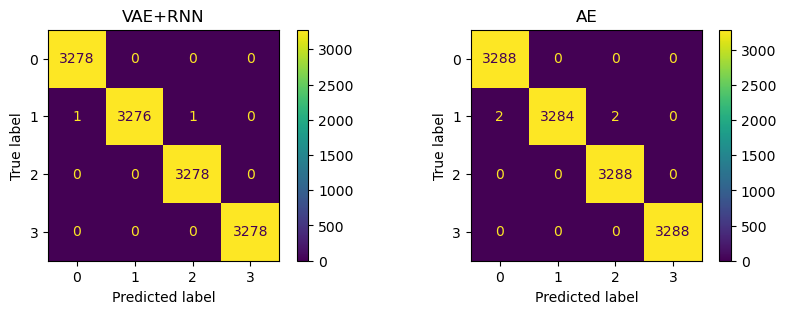

ROC Curve:


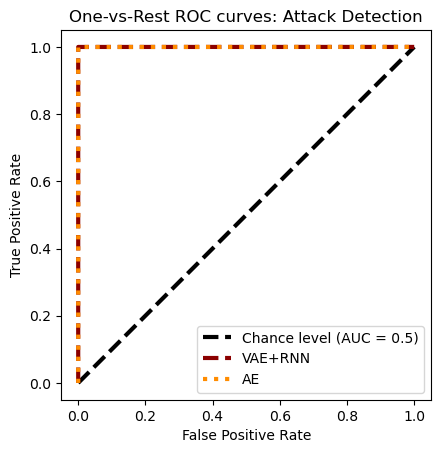

In [15]:
severity = 5
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.959321  1.000000  0.979238      3278
           1   1.000000  0.965528  0.982462      3278
           2   1.000000  0.999085  0.999542      3278
           3   1.000000  0.992984  0.996479      3278

    accuracy                       0.989399     13112
   macro avg   0.989830  0.989399  0.989430     13112
weighted avg   0.989830  0.989399  0.989430     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.913587  1.000000  0.954842      3288
           1   1.000000  1.000000  1.000000      3288
           2   0.999388  0.993005  0.996186      3288
           3   1.000000  0.911800  0.953866      3288

    accuracy                       0.976201     13152
   macro avg   0.978244  0.976201  0.976224     13152
weighted avg   0.978244  0.976201  0.976224     13152

Confusion Matrix:


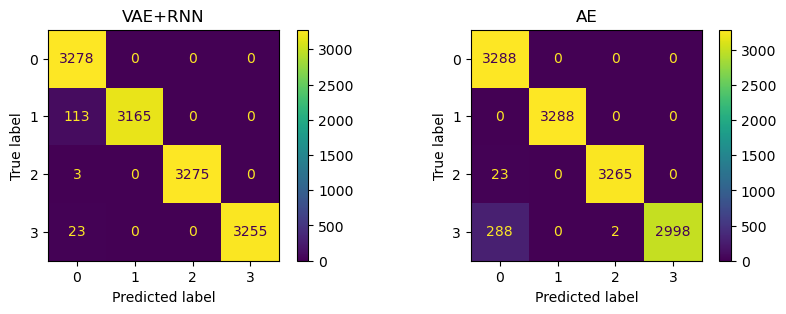

ROC Curve:


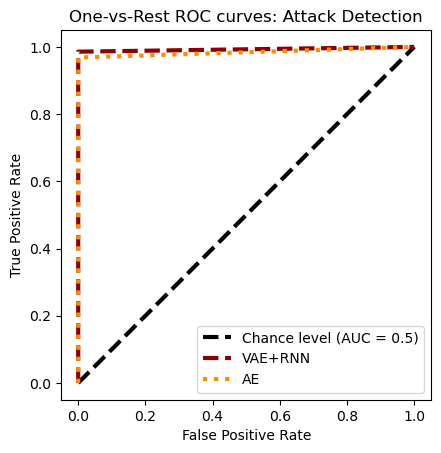

In [16]:
severity = 6
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.252270  1.000000  0.402901      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   1.000000  0.035998  0.069494      3278

    accuracy                       0.258999     13112
   macro avg   0.313068  0.258999  0.118099     13112
weighted avg   0.313068  0.258999  0.118099     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.506938  1.000000  0.672805      3288
           1   1.000000  0.920620  0.958670      3288
           2   1.000000  0.914538  0.955361      3288
           3   1.000000  0.192214  0.322449      3288

    accuracy                       0.756843     13152
   macro avg   0.876735  0.756843  0.727321     13152
weighted avg   0.876735  0.756843  0.727321     13152

Confusion Matrix:


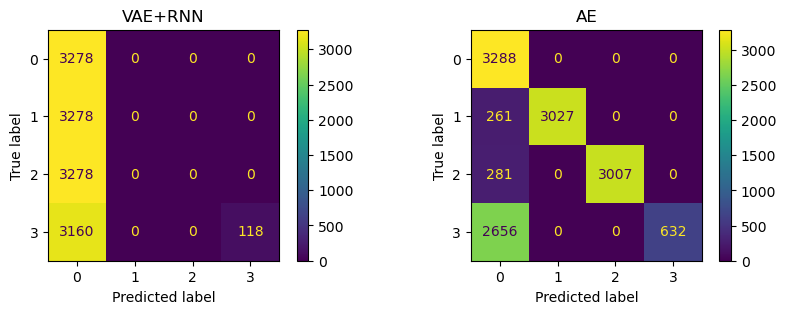

ROC Curve:


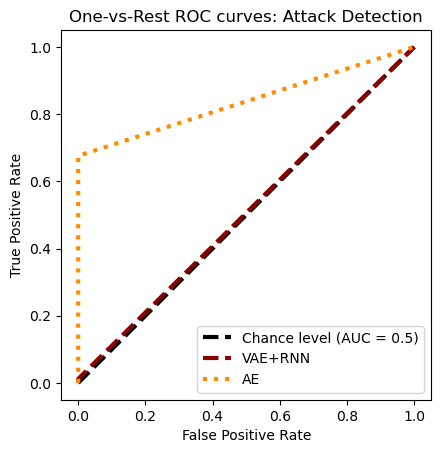

In [17]:
severity = 7
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.250000  1.000000  0.400000      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   0.000000  0.000000  0.000000      3278

    accuracy                       0.250000     13112
   macro avg   0.062500  0.250000  0.100000     13112
weighted avg   0.062500  0.250000  0.100000     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.262076  1.000000  0.415309      3288
           1   0.000000  0.000000  0.000000      3288
           2   1.000000  0.178224  0.302530      3288
           3   0.900000  0.005474  0.010883      3288

    accuracy                       0.295925     13152
   macro avg   0.540519  0.295925  0.182180     13152
weighted avg   0.540519  0.295925  0.182180     13152

Confusion Matrix:


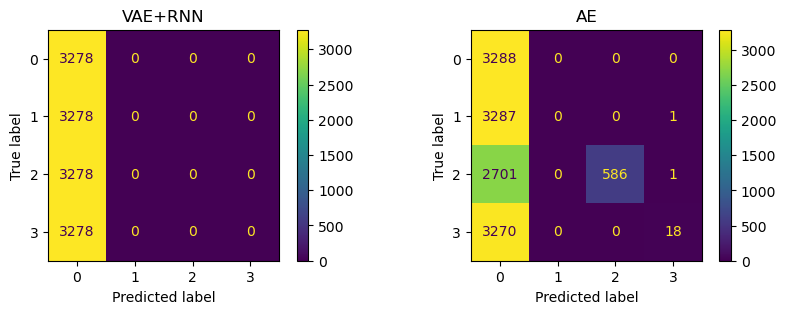

ROC Curve:


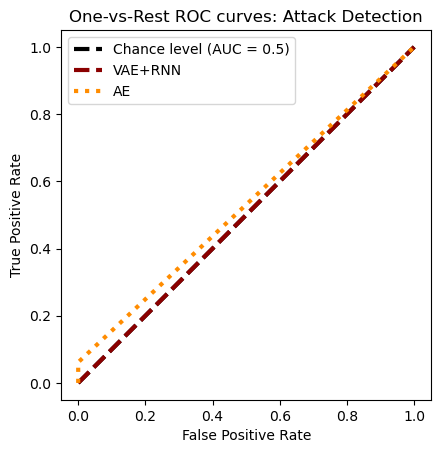

In [18]:
severity = 8
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.250000  1.000000  0.400000      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   0.000000  0.000000  0.000000      3278

    accuracy                       0.250000     13112
   macro avg   0.062500  0.250000  0.100000     13112
weighted avg   0.062500  0.250000  0.100000     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.250209  1.000000  0.400268      3288
           1   0.000000  0.000000  0.000000      3288
           2   1.000000  0.001217  0.002430      3288
           3   0.428571  0.000912  0.001821      3288

    accuracy                       0.250532     13152
   macro avg   0.419695  0.250532  0.101130     13152
weighted avg   0.419695  0.250532  0.101130     13152

Confusion Matrix:


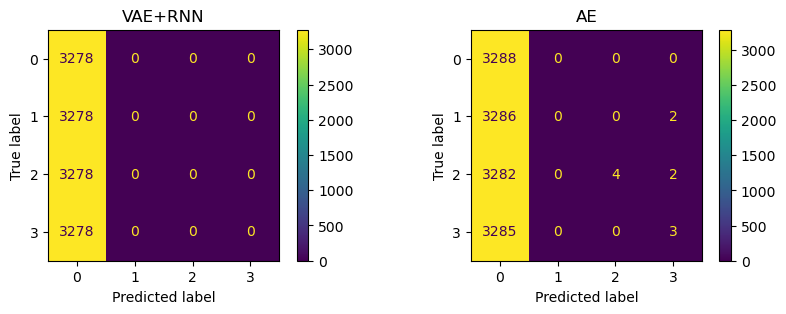

ROC Curve:


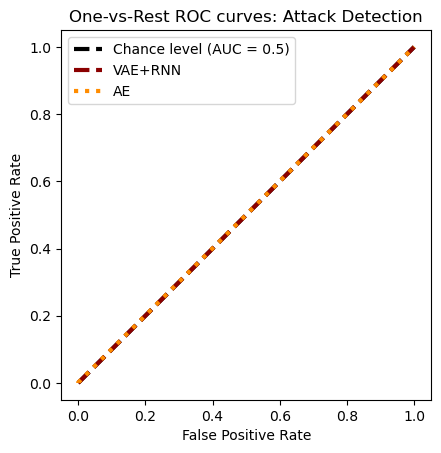

In [19]:
severity = 9
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

### **Confusion Matrix: Noise Level 5%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.999390  1.000000  0.999695      3278
           1   1.000000  0.999085  0.999542      3278
           2   0.999695  1.000000  0.999847      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       0.999771     13112
   macro avg   0.999771  0.999771  0.999771     13112
weighted avg   0.999771  0.999771  0.999771     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.965345  0.999696  0.982220      3288
           1   1.000000  0.998783  0.999391      3288
           2   0.999391  0.998783  0.999087      3288
           3   0.999685  0.965937  0.982521      3288

    accuracy                       0.990800     13152
   macro avg   0.991105  0.990800  0.990805     13152
weighted avg   0.991105  0.990800  0.990805     13152

Confusion Matrix:


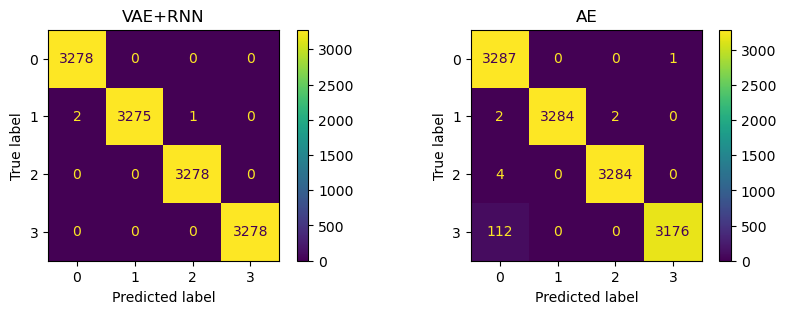

ROC Curve:


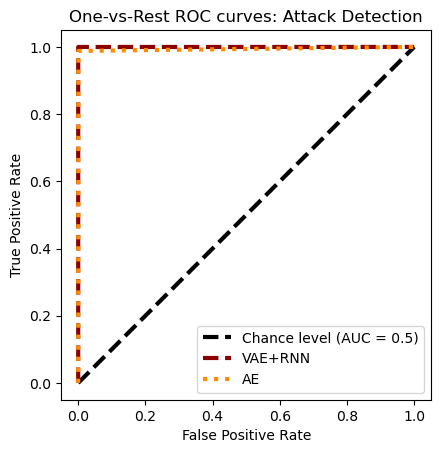

In [20]:
severity = 5
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.949594  1.000000  0.974146      3278
           1   1.000000  0.965528  0.982462      3278
           2   1.000000  0.998780  0.999389      3278
           3   1.000000  0.982611  0.991229      3278

    accuracy                       0.986730     13112
   macro avg   0.987399  0.986730  0.986807     13112
weighted avg   0.987399  0.986730  0.986807     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.778725  0.999696  0.875483      3288
           1   1.000000  0.998783  0.999391      3288
           2   1.000000  0.975669  0.987685      3288
           3   0.999590  0.741484  0.851406      3288

    accuracy                       0.928908     13152
   macro avg   0.944579  0.928908  0.928491     13152
weighted avg   0.944579  0.928908  0.928491     13152

Confusion Matrix:


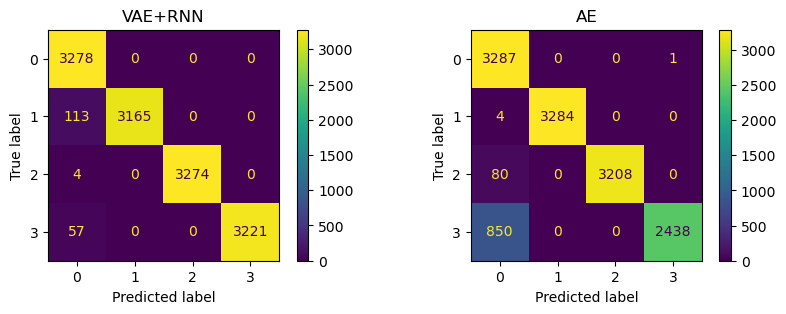

ROC Curve:


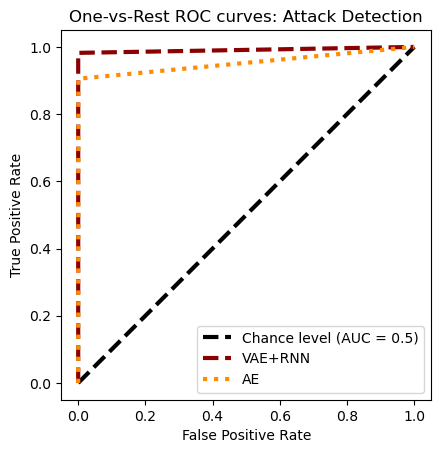

In [21]:
severity = 6
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.251034  1.000000  0.401322      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   1.000000  0.016473  0.032413      3278

    accuracy                       0.254118     13112
   macro avg   0.312758  0.254118  0.108434     13112
weighted avg   0.312758  0.254118  0.108434     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.473836  0.999696  0.642934      3288
           1   1.000000  0.769161  0.869520      3288
           2   1.000000  0.804440  0.891623      3288
           3   0.999039  0.316302  0.480480      3288

    accuracy                       0.722400     13152
   macro avg   0.868219  0.722400  0.721139     13152
weighted avg   0.868219  0.722400  0.721139     13152

Confusion Matrix:


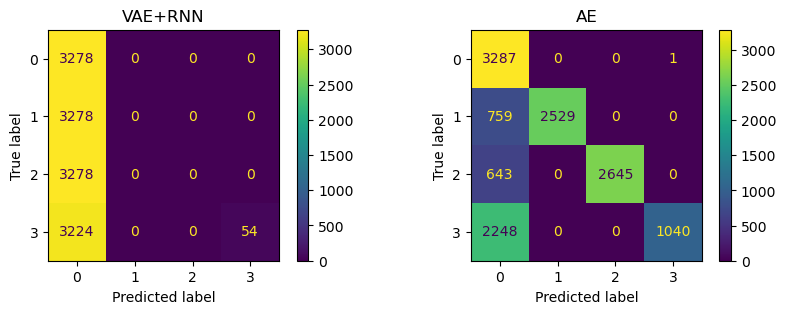

ROC Curve:


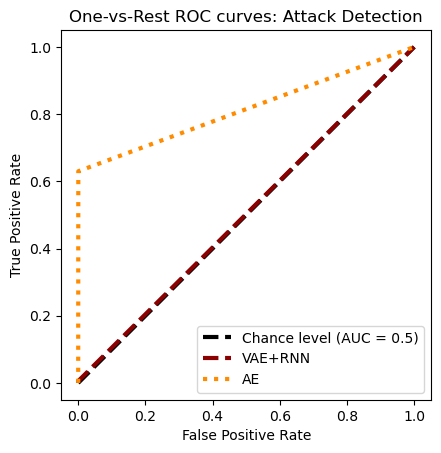

In [22]:
severity = 7
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.250000  1.000000  0.400000      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   0.000000  0.000000  0.000000      3278

    accuracy                       0.250000     13112
   macro avg   0.062500  0.250000  0.100000     13112
weighted avg   0.062500  0.250000  0.100000     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.267715  0.999696  0.422331      3288
           1   1.000000  0.002433  0.004854      3288
           2   1.000000  0.184915  0.312115      3288
           3   0.961240  0.075426  0.139876      3288

    accuracy                       0.315617     13152
   macro avg   0.807239  0.315617  0.219794     13152
weighted avg   0.807239  0.315617  0.219794     13152

Confusion Matrix:


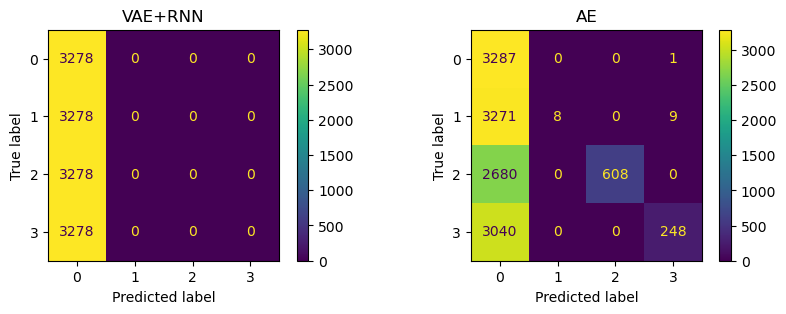

ROC Curve:


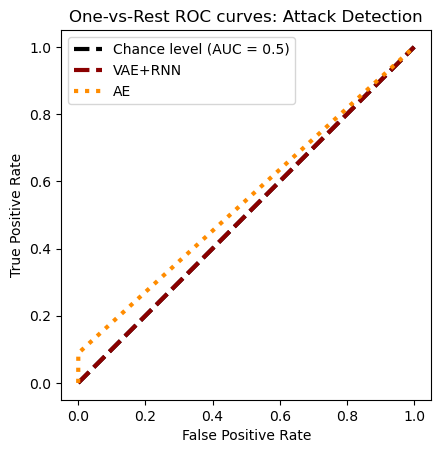

In [23]:
severity = 8
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.250000  1.000000  0.400000      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   0.000000  0.000000  0.000000      3278

    accuracy                       0.250000     13112
   macro avg   0.062500  0.250000  0.100000     13112
weighted avg   0.062500  0.250000  0.100000     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.251704  0.999696  0.402153      3288
           1   0.000000  0.000000  0.000000      3288
           2   1.000000  0.002433  0.004854      3288
           3   0.611765  0.015815  0.030833      3288

    accuracy                       0.254486     13152
   macro avg   0.465867  0.254486  0.109460     13152
weighted avg   0.465867  0.254486  0.109460     13152

Confusion Matrix:


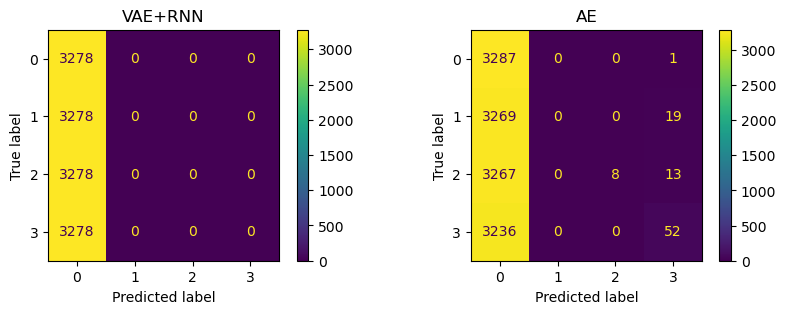

ROC Curve:


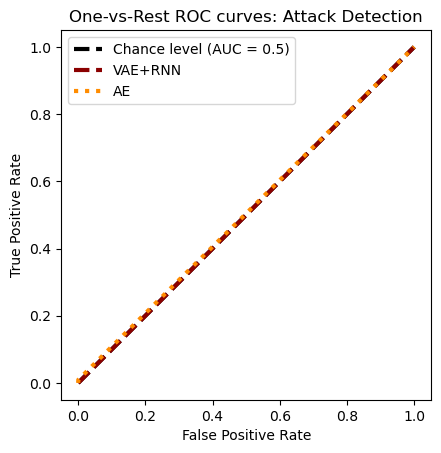

In [24]:
severity = 9
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

### **Confusion Matrix: Noise Level 10%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.999390  1.000000  0.999695      3278
           1   1.000000  0.999085  0.999542      3278
           2   0.999695  1.000000  0.999847      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       0.999771     13112
   macro avg   0.999771  0.999771  0.999771     13112
weighted avg   0.999771  0.999771  0.999771     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.946609  0.997567  0.971420      3288
           1   1.000000  0.998783  0.999391      3288
           2   0.999392  0.999696  0.999544      3288
           3   0.997431  0.944647  0.970322      3288

    accuracy                       0.985173     13152
   macro avg   0.985858  0.985173  0.985169     13152
weighted avg   0.985858  0.985173  0.985169     13152

Confusion Matrix:


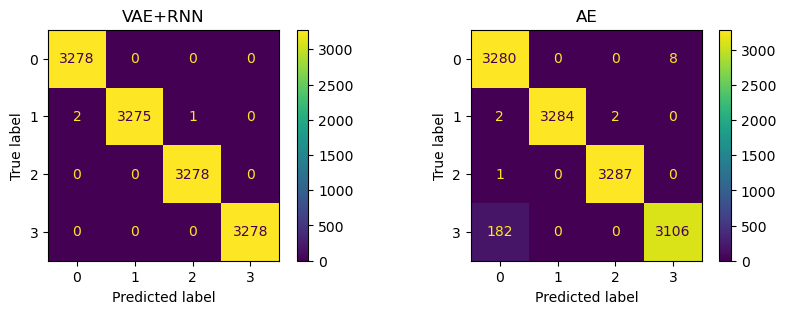

ROC Curve:


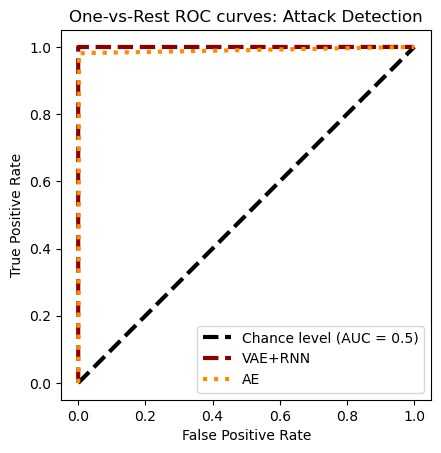

In [25]:
severity = 5
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.972989  1.000000  0.986310      3278
           1   1.000000  0.990238  0.995095      3278
           2   1.000000  0.998780  0.999389      3278
           3   1.000000  0.983221  0.991540      3278

    accuracy                       0.993060     13112
   macro avg   0.993247  0.993060  0.993083     13112
weighted avg   0.993247  0.993060  0.993083     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.751604  0.997567  0.857292      3288
           1   1.000000  0.995134  0.997561      3288
           2   1.000000  0.974453  0.987061      3288
           3   0.996540  0.700730  0.822857      3288

    accuracy                       0.916971     13152
   macro avg   0.937036  0.916971  0.916193     13152
weighted avg   0.937036  0.916971  0.916193     13152

Confusion Matrix:


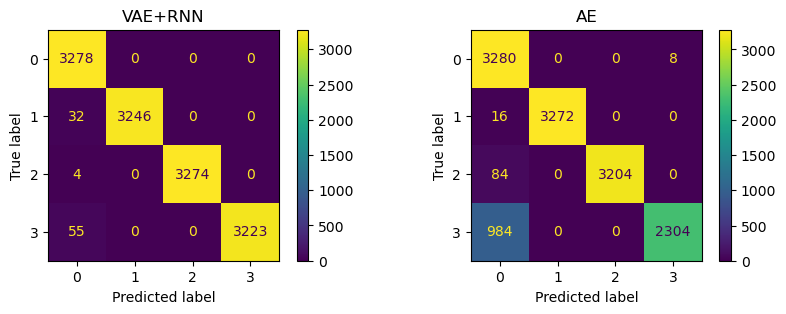

ROC Curve:


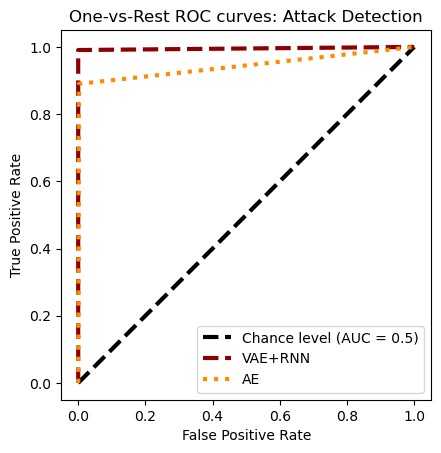

In [26]:
severity = 6
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.250938  1.000000  0.401199      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   1.000000  0.014948  0.029456      3278

    accuracy                       0.253737     13112
   macro avg   0.312734  0.253737  0.107664     13112
weighted avg   0.312734  0.253737  0.107664     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.476052  0.997567  0.644527      3288
           1   1.000000  0.783151  0.878390      3288
           2   0.999624  0.809307  0.894454      3288
           3   0.988293  0.308090  0.469743      3288

    accuracy                       0.724529     13152
   macro avg   0.865992  0.724529  0.721778     13152
weighted avg   0.865992  0.724529  0.721778     13152

Confusion Matrix:


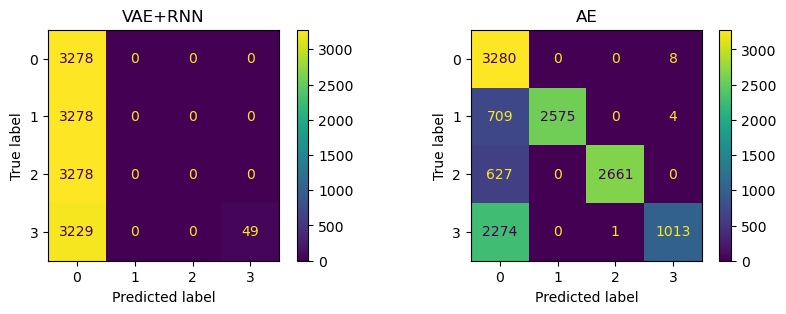

ROC Curve:


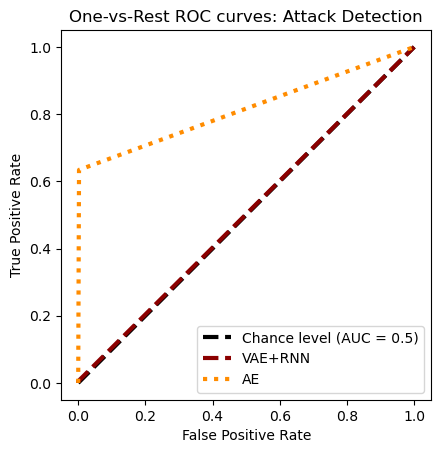

In [27]:
severity = 7
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.250000  1.000000  0.400000      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   0.000000  0.000000  0.000000      3278

    accuracy                       0.250000     13112
   macro avg   0.062500  0.250000  0.100000     13112
weighted avg   0.062500  0.250000  0.100000     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.274891  0.997567  0.431012      3288
           1   1.000000  0.024027  0.046926      3288
           2   0.998798  0.252737  0.403398      3288
           3   0.870550  0.081813  0.149569      3288

    accuracy                       0.339036     13152
   macro avg   0.786060  0.339036  0.257726     13152
weighted avg   0.786060  0.339036  0.257726     13152

Confusion Matrix:


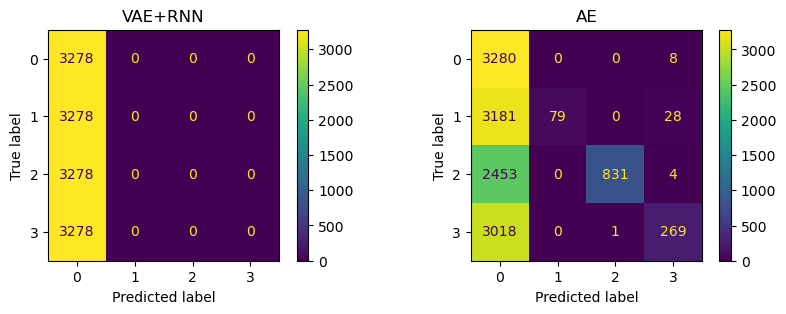

ROC Curve:


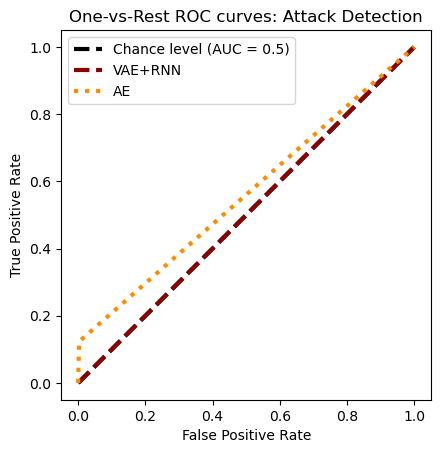

In [28]:
severity = 8
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.250000  1.000000  0.400000      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   0.000000  0.000000  0.000000      3278

    accuracy                       0.250000     13112
   macro avg   0.062500  0.250000  0.100000     13112
weighted avg   0.062500  0.250000  0.100000     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.253204  0.997567  0.403891      3288
           1   0.000000  0.000000  0.000000      3288
           2   1.000000  0.002433  0.004854      3288
           3   0.489474  0.028285  0.053479      3288

    accuracy                       0.257071     13152
   macro avg   0.435669  0.257071  0.115556     13152
weighted avg   0.435669  0.257071  0.115556     13152

Confusion Matrix:


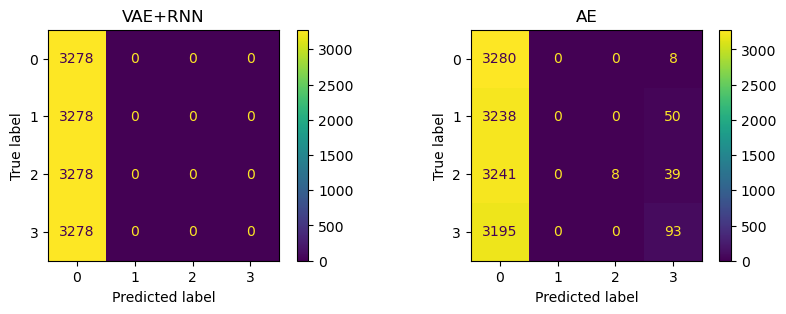

ROC Curve:


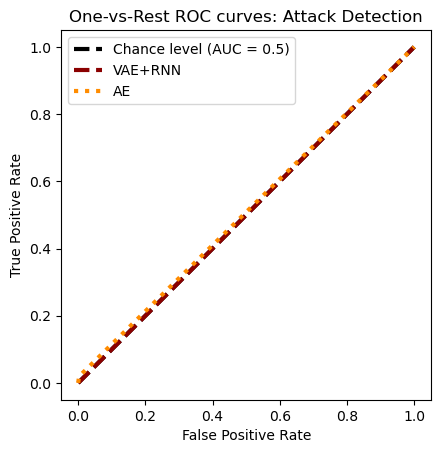

In [29]:
severity = 9
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

### **Confusion Matrix: Noise Level 20%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.999390  1.000000  0.999695      3278
           1   1.000000  0.999085  0.999542      3278
           2   0.999695  1.000000  0.999847      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       0.999771     13112
   macro avg   0.999771  0.999771  0.999771     13112
weighted avg   0.999771  0.999771  0.999771     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.995760  1.000000  0.997876      3288
           1   1.000000  0.998783  0.999391      3288
           2   0.999392  1.000000  0.999696      3288
           3   1.000000  0.996350  0.998172      3288

    accuracy                       0.998783     13152
   macro avg   0.998788  0.998783  0.998784     13152
weighted avg   0.998788  0.998783  0.998784     13152

Confusion Matrix:


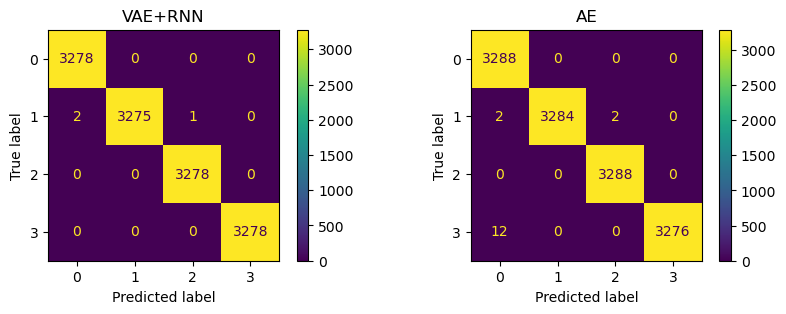

ROC Curve:


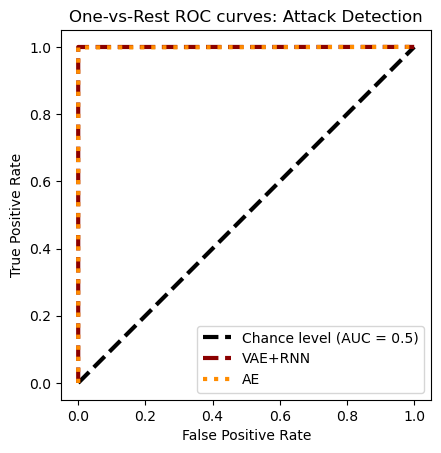

In [30]:
severity = 5
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.941954  1.000000  0.970109      3278
           1   1.000000  0.989628  0.994787      3278
           2   1.000000  0.998780  0.999389      3278
           3   1.000000  0.949969  0.974343      3278

    accuracy                       0.984594     13112
   macro avg   0.985489  0.984594  0.984657     13112
weighted avg   0.985489  0.984594  0.984657     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.853140  1.000000  0.920750      3288
           1   1.000000  1.000000  1.000000      3288
           2   1.000000  0.992701  0.996337      3288
           3   1.000000  0.835158  0.910176      3288

    accuracy                       0.956965     13152
   macro avg   0.963285  0.956965  0.956816     13152
weighted avg   0.963285  0.956965  0.956816     13152

Confusion Matrix:


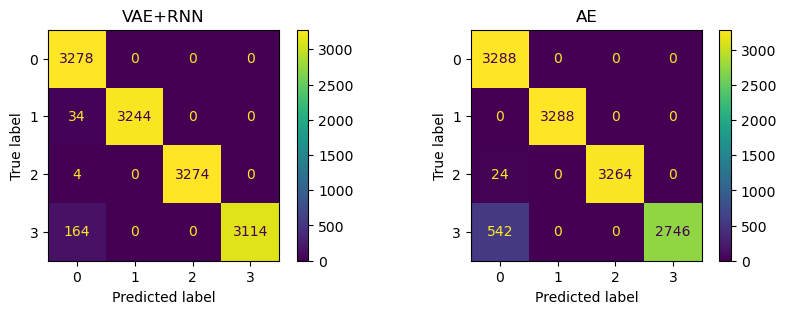

ROC Curve:


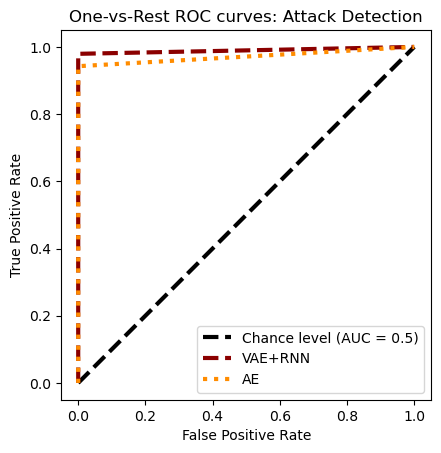

In [31]:
severity = 6
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.250134  1.000000  0.400171      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   1.000000  0.002135  0.004262      3278

    accuracy                       0.250534     13112
   macro avg   0.312533  0.250534  0.101108     13112
weighted avg   0.312533  0.250534  0.101108     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.500000  1.000000  0.666667      3288
           1   1.000000  0.821776  0.902170      3288
           2   1.000000  0.872567  0.931947      3288
           3   1.000000  0.305657  0.468204      3288

    accuracy                       0.750000     13152
   macro avg   0.875000  0.750000  0.742247     13152
weighted avg   0.875000  0.750000  0.742247     13152

Confusion Matrix:


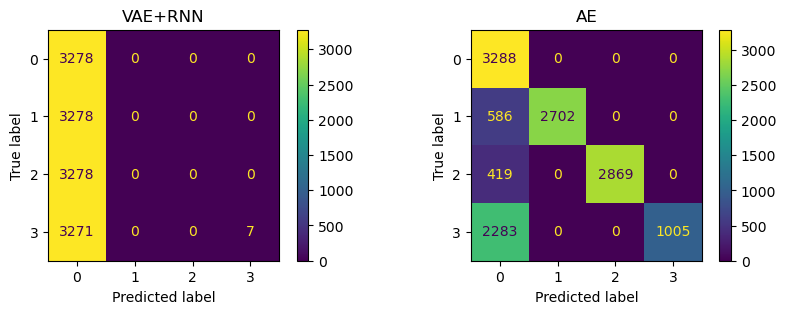

ROC Curve:


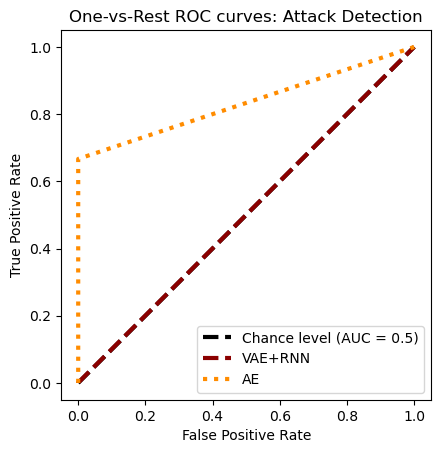

In [32]:
severity = 7
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.250000  1.000000  0.400000      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   0.000000  0.000000  0.000000      3278

    accuracy                       0.250000     13112
   macro avg   0.062500  0.250000  0.100000     13112
weighted avg   0.062500  0.250000  0.100000     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.262201  1.000000  0.415466      3288
           1   1.000000  0.000304  0.000608      3288
           2   1.000000  0.164538  0.282580      3288
           3   0.942857  0.020073  0.039309      3288

    accuracy                       0.296229     13152
   macro avg   0.801265  0.296229  0.184491     13152
weighted avg   0.801265  0.296229  0.184491     13152

Confusion Matrix:


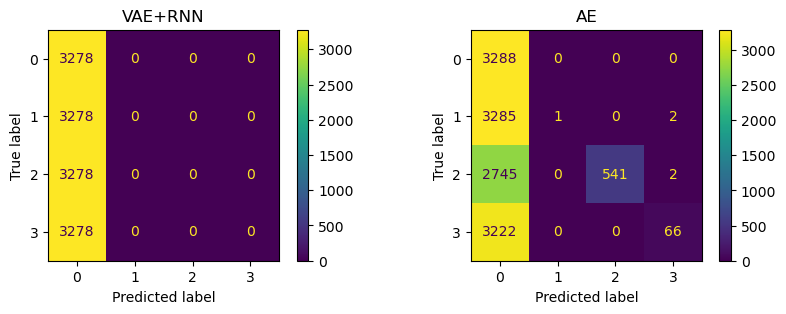

ROC Curve:


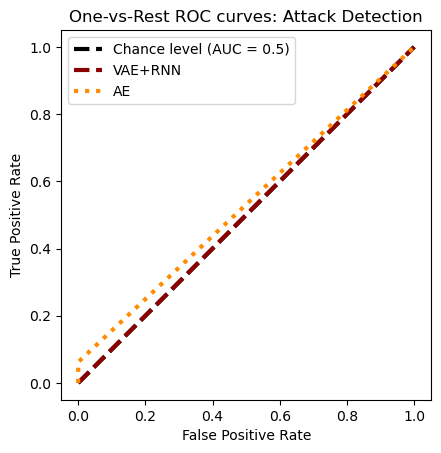

In [33]:
severity = 8
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.250000  1.000000  0.400000      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   0.000000  0.000000  0.000000      3278

    accuracy                       0.250000     13112
   macro avg   0.062500  0.250000  0.100000     13112
weighted avg   0.062500  0.250000  0.100000     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.250343  1.000000  0.400438      3288
           1   0.000000  0.000000  0.000000      3288
           2   1.000000  0.000912  0.001823      3288
           3   0.600000  0.002737  0.005450      3288

    accuracy                       0.250912     13152
   macro avg   0.462586  0.250912  0.101928     13152
weighted avg   0.462586  0.250912  0.101928     13152

Confusion Matrix:


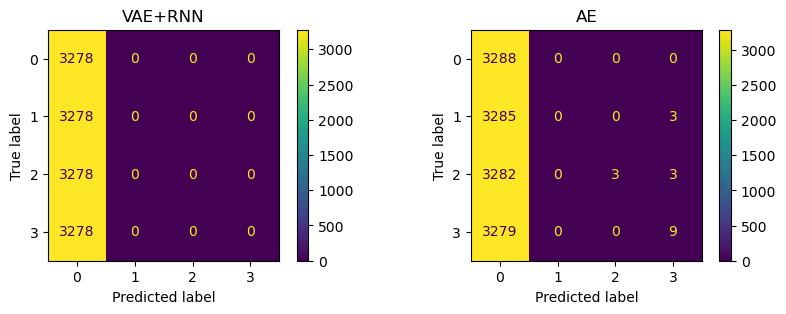

ROC Curve:


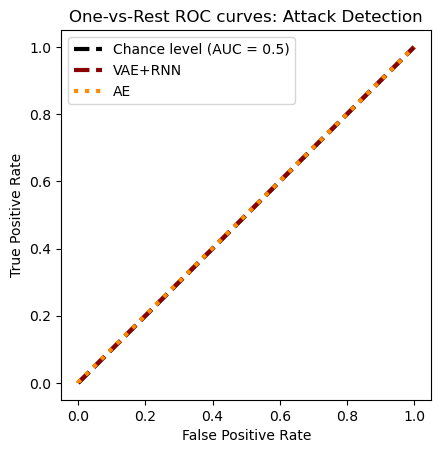

In [34]:
severity = 9
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

### **Confusion Matrix: Noise Level 50%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.999390  1.000000  0.999695      3278
           1   1.000000  0.999085  0.999542      3278
           2   0.999695  1.000000  0.999847      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       0.999771     13112
   macro avg   0.999771  0.999771  0.999771     13112
weighted avg   0.999771  0.999771  0.999771     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.999088  1.000000  0.999544      3288
           1   1.000000  0.998783  0.999391      3288
           2   0.999088  1.000000  0.999544      3288
           3   1.000000  0.999392  0.999696      3288

    accuracy                       0.999544     13152
   macro avg   0.999544  0.999544  0.999544     13152
weighted avg   0.999544  0.999544  0.999544     13152

Confusion Matrix:


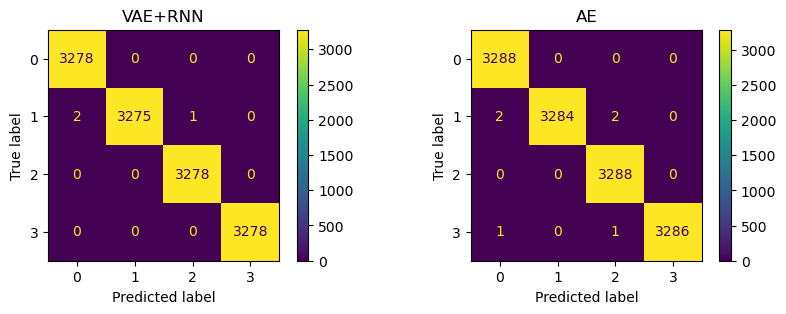

ROC Curve:


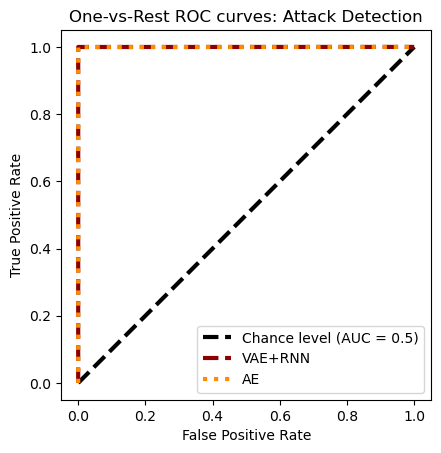

In [35]:
severity = 5
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.963834  1.000000  0.981584      3278
           1   1.000000  0.974070  0.986864      3278
           2   1.000000  0.999085  0.999542      3278
           3   1.000000  0.989323  0.994633      3278

    accuracy                       0.990619     13112
   macro avg   0.990959  0.990619  0.990656     13112
weighted avg   0.990959  0.990619  0.990656     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.916899  1.000000  0.956648      3288
           1   1.000000  1.000000  1.000000      3288
           2   0.999696  0.999088  0.999392      3288
           3   1.000000  0.909976  0.952866      3288

    accuracy                       0.977266     13152
   macro avg   0.979149  0.977266  0.977227     13152
weighted avg   0.979149  0.977266  0.977227     13152

Confusion Matrix:


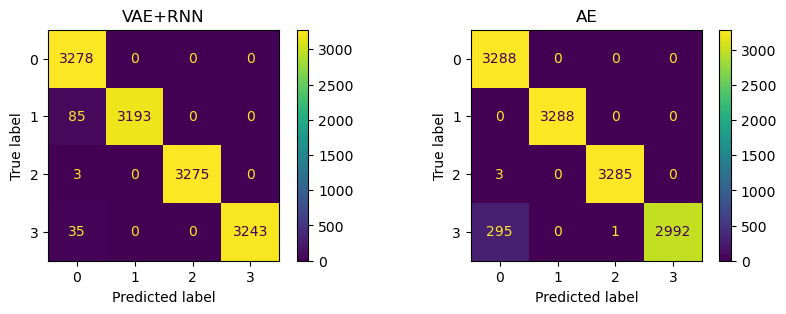

ROC Curve:


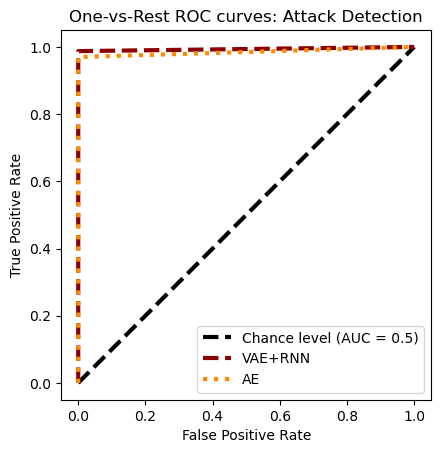

In [36]:
severity = 6
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.251554  1.000000  0.401987      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   1.000000  0.024710  0.048229      3278

    accuracy                       0.256178     13112
   macro avg   0.312888  0.256178  0.112554     13112
weighted avg   0.312888  0.256178  0.112554     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.402694  1.000000  0.574173      3288
           1   1.000000  0.598236  0.748620      3288
           2   0.999255  0.815389  0.898007      3288
           3   0.997033  0.102190  0.185379      3288

    accuracy                       0.628954     13152
   macro avg   0.849745  0.628954  0.601545     13152
weighted avg   0.849745  0.628954  0.601545     13152

Confusion Matrix:


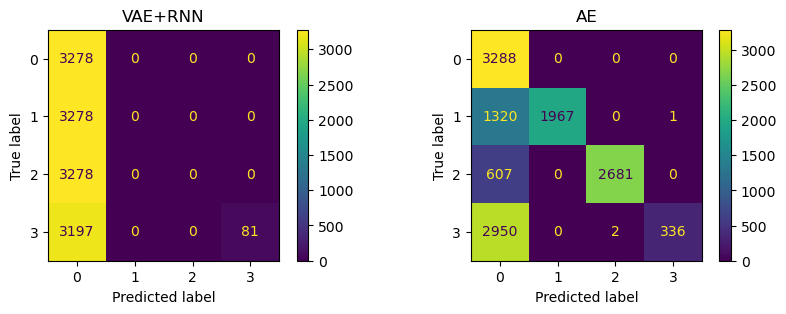

ROC Curve:


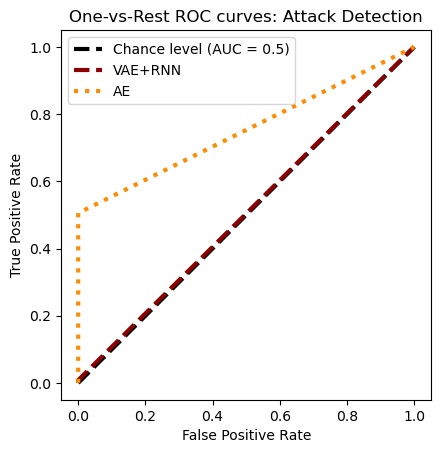

In [37]:
severity = 7
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.250000  1.000000  0.400000      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   0.000000  0.000000  0.000000      3278

    accuracy                       0.250000     13112
   macro avg   0.062500  0.250000  0.100000     13112
weighted avg   0.062500  0.250000  0.100000     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.251626  1.000000  0.402079      3288
           1   0.000000  0.000000  0.000000      3288
           2   0.964286  0.016423  0.032297      3288
           3   0.793103  0.006995  0.013868      3288

    accuracy                       0.255855     13152
   macro avg   0.502254  0.255855  0.112061     13152
weighted avg   0.502254  0.255855  0.112061     13152

Confusion Matrix:


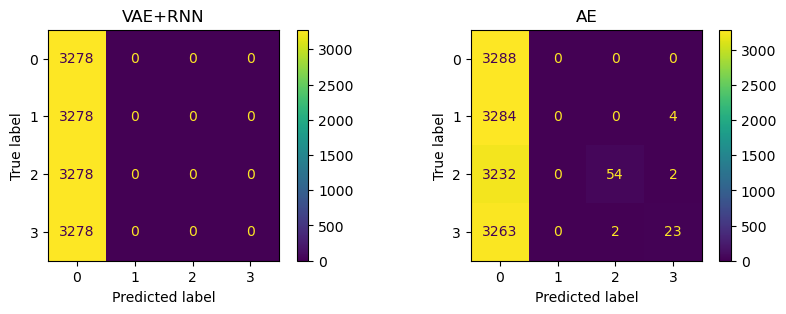

ROC Curve:


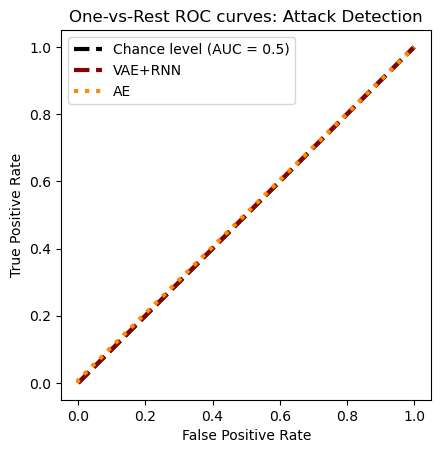

In [38]:
severity = 8
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.250000  1.000000  0.400000      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   0.000000  0.000000  0.000000      3278

    accuracy                       0.250000     13112
   macro avg   0.062500  0.250000  0.100000     13112
weighted avg   0.062500  0.250000  0.100000     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.250457  1.000000  0.400585      3288
           1   0.000000  0.000000  0.000000      3288
           2   0.555556  0.001521  0.003033      3288
           3   0.400000  0.001825  0.003633      3288

    accuracy                       0.250836     13152
   macro avg   0.301503  0.250836  0.101813     13152
weighted avg   0.301503  0.250836  0.101813     13152

Confusion Matrix:


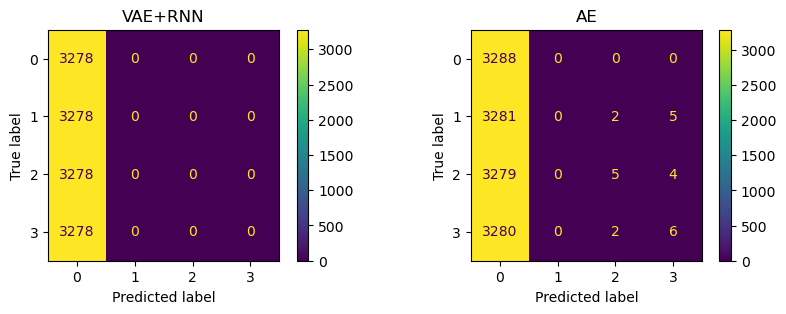

ROC Curve:


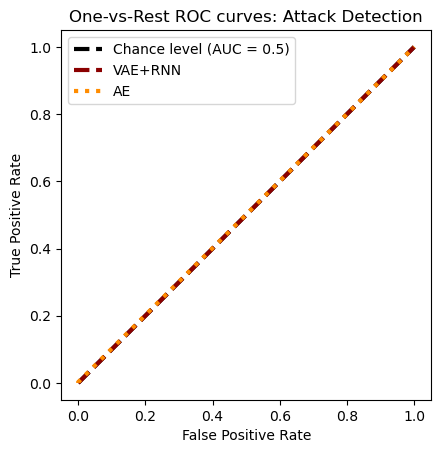

In [39]:
severity = 9
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

## **Quantiles**

In [40]:
q = torch.tensor([0.025, 0.975])
x_ax = ['0%', '%5', '%10', '%20', '50%']

### **Quantiles: Attack Severity 5**

In [41]:
severity = 5
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
_min, _max = defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                _low, _up = torch.quantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00, 36.09it/s]


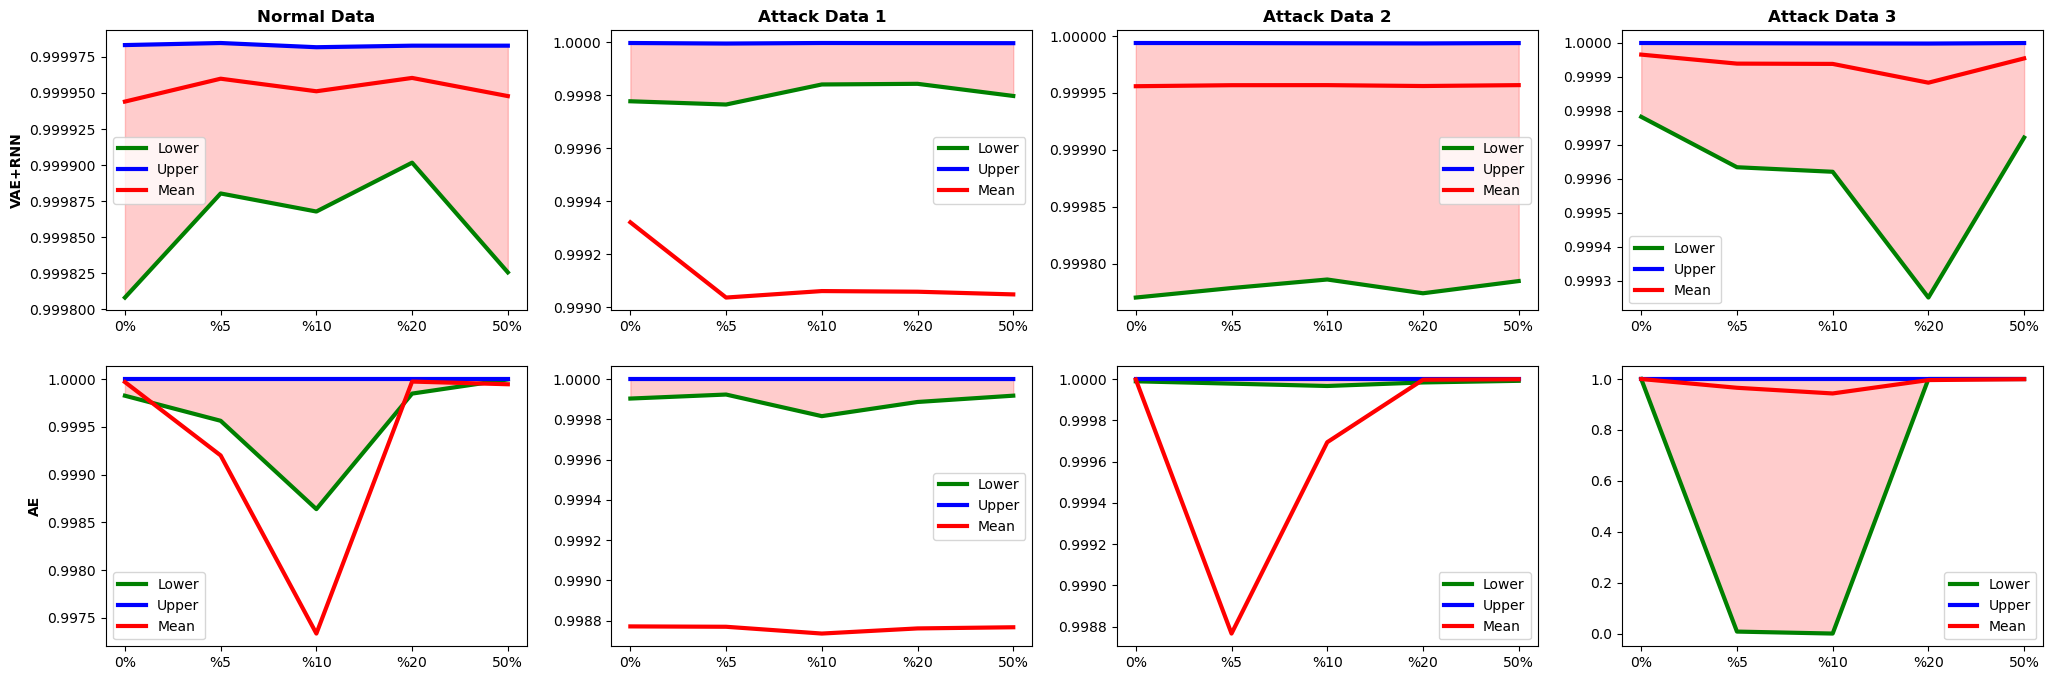

In [42]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(25, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mean[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mean', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.show()

### **Quantiles: Attack Severity 6**

In [43]:
severity = 6
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
_min, _max = defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                _low, _up = torch.quantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00, 40.61it/s]


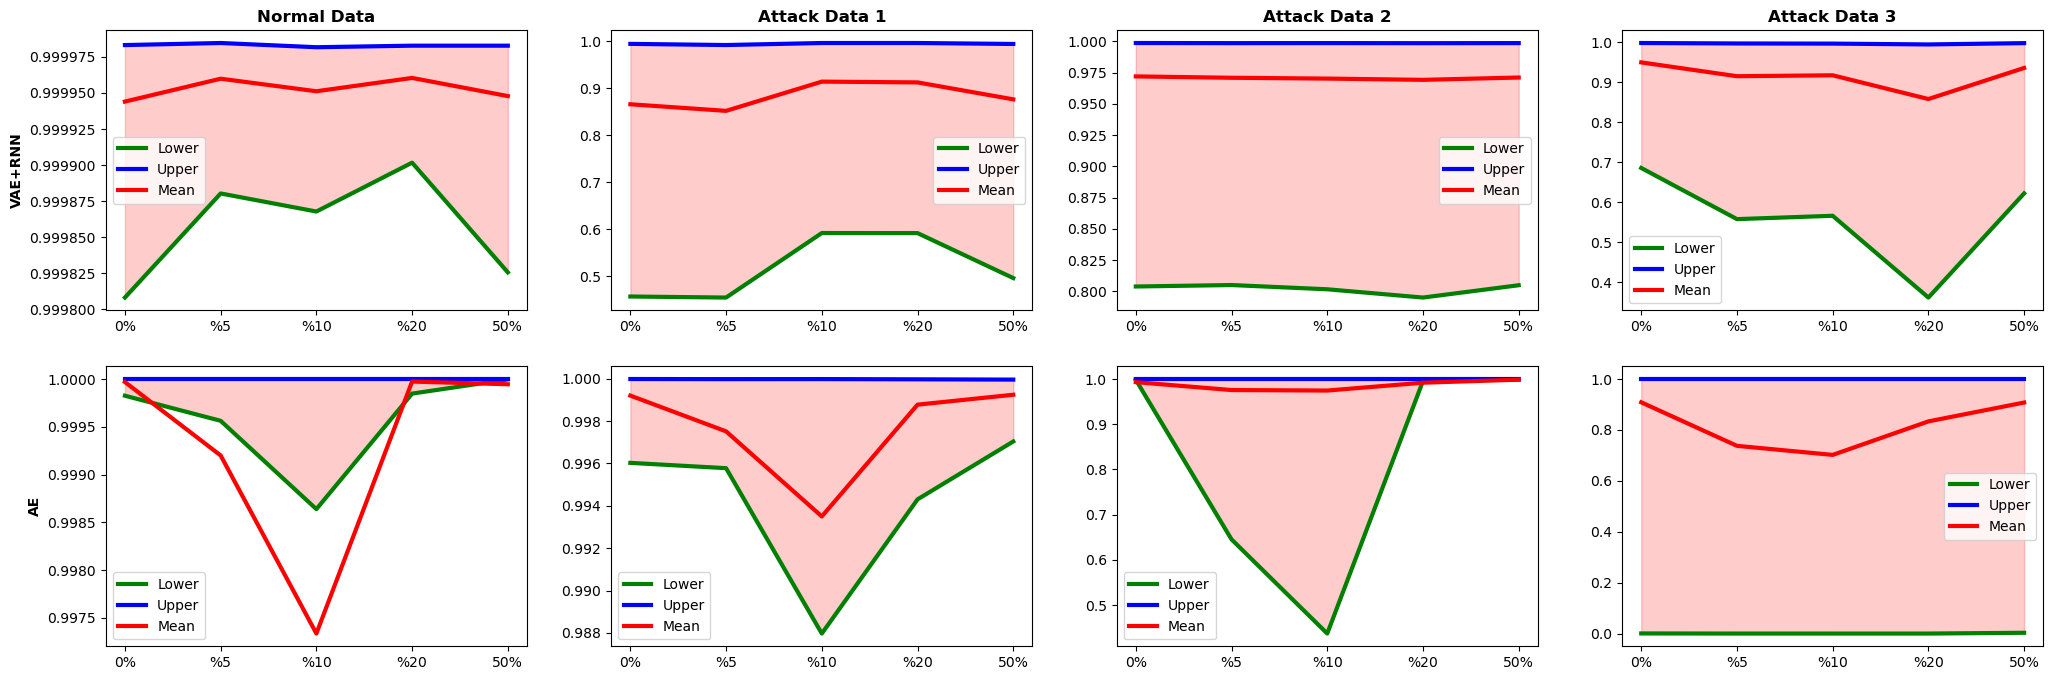

In [44]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(25, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mean[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mean', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.show()

### **Quantiles: Attack Severity 7**

In [45]:
severity = 7
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
_min, _max = defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                _low, _up = torch.quantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00, 26.12it/s]


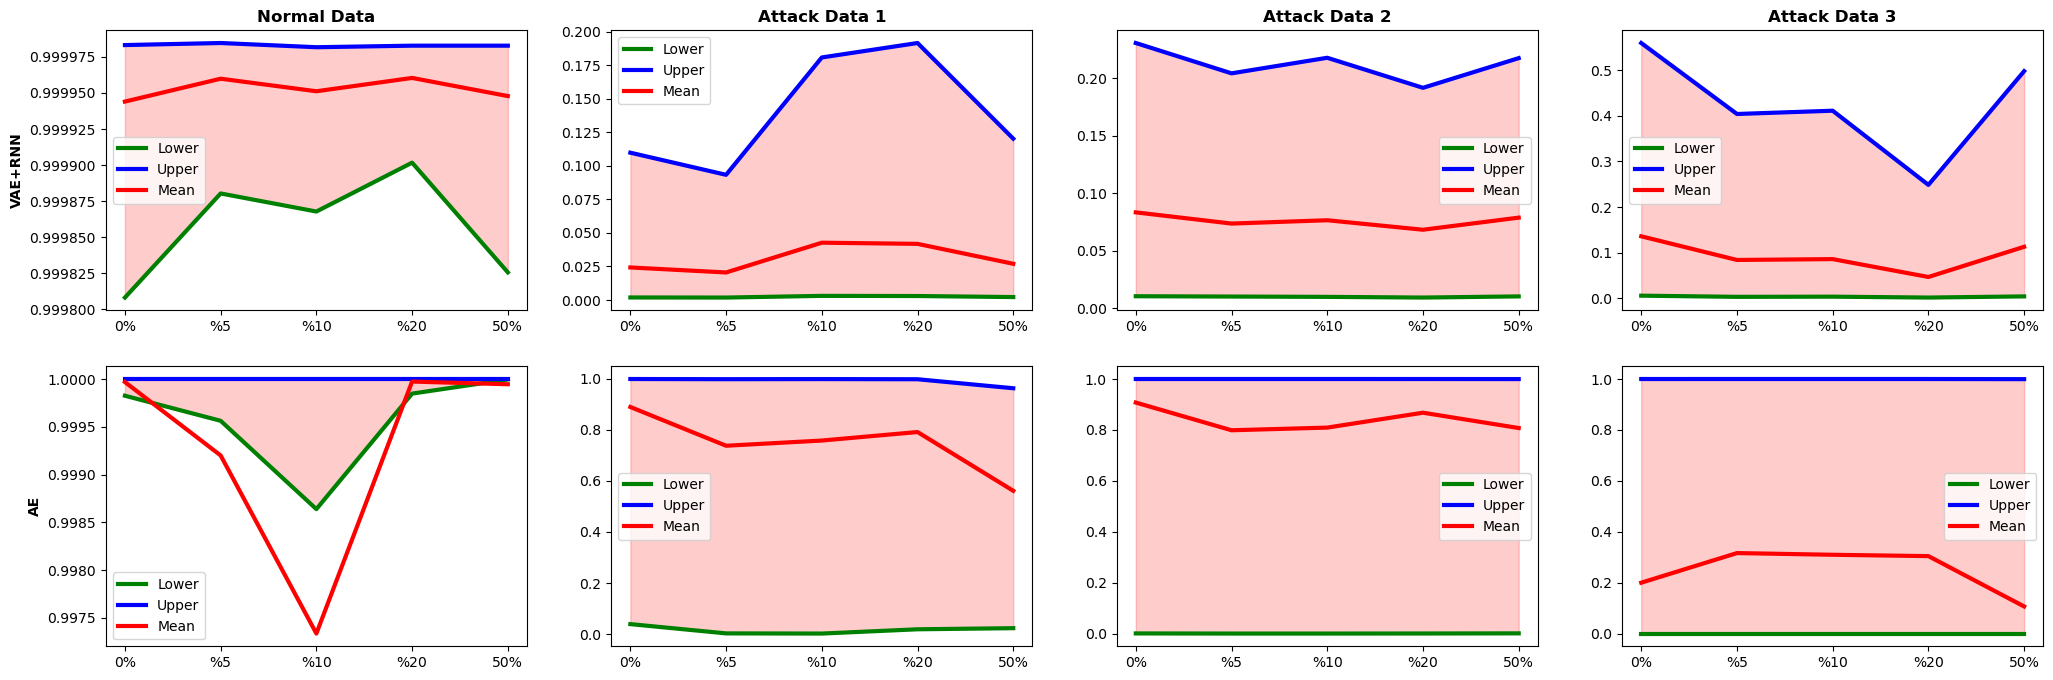

In [46]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(25, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mean[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mean', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.show()

### **Quantiles: Attack Severity 8**

In [47]:
severity = 8
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
_min, _max = defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                _low, _up = torch.quantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


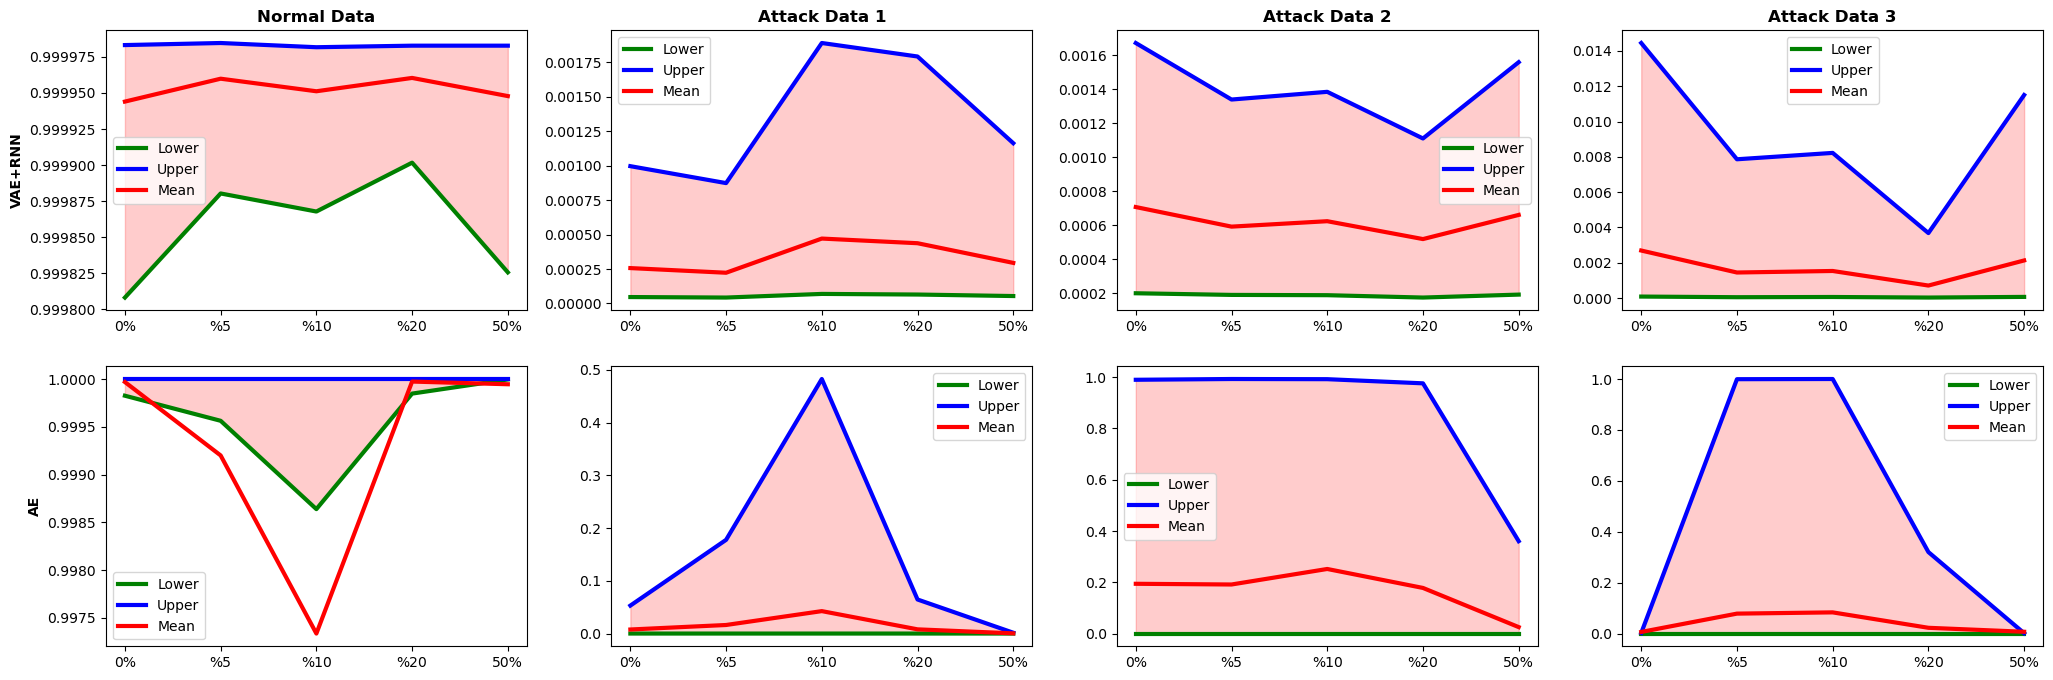

In [48]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(25, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mean[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mean', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.show()

### **Quantiles: Attack Severity 9**

In [49]:
severity = 9
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
_min, _max = defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                _low, _up = torch.quantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00, 14.28it/s]


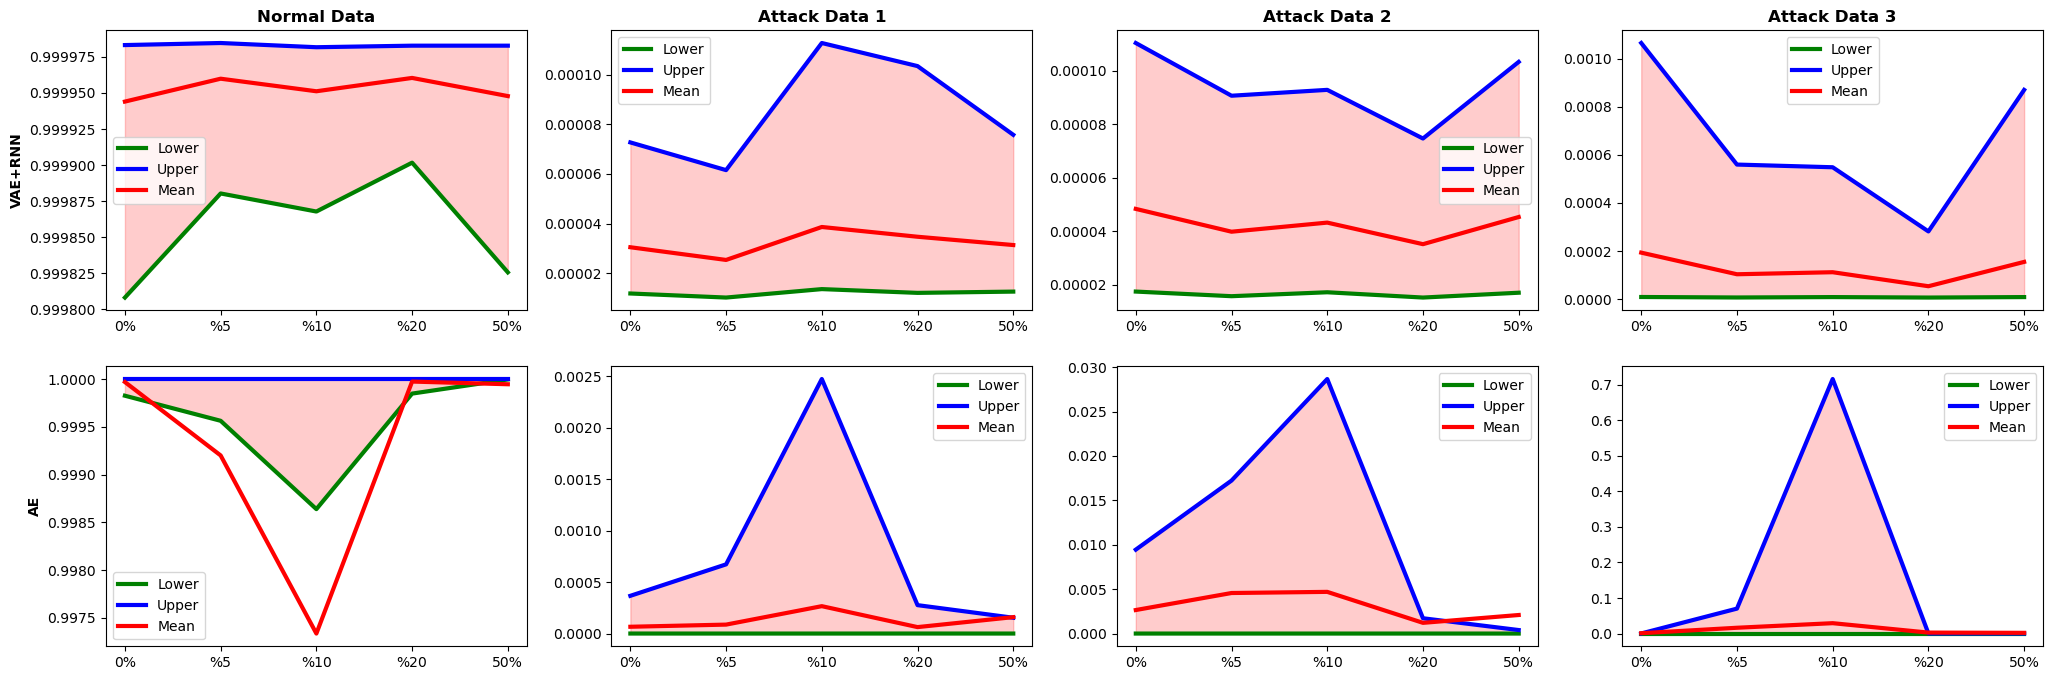

In [50]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(25, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mean[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mean', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.show()

## **Detection-Localozation Accuracy**

In [51]:
detection, localization = defaultdict(list), defaultdict(list)
for k in pred.keys():
    for severity in range(5,10):
        for level in noise_levels:
            pp = torch.argmax(pred[k][level,severity], dim=1).numpy()
            yy = torch.argmax(y[k], dim=1).numpy()
            localization[k, severity].append(metrics.accuracy_score(yy, pp))
            yy[yy>0] = 1
            pp[pp>0] = 1
            detection[k, severity].append(metrics.accuracy_score(yy,pp))

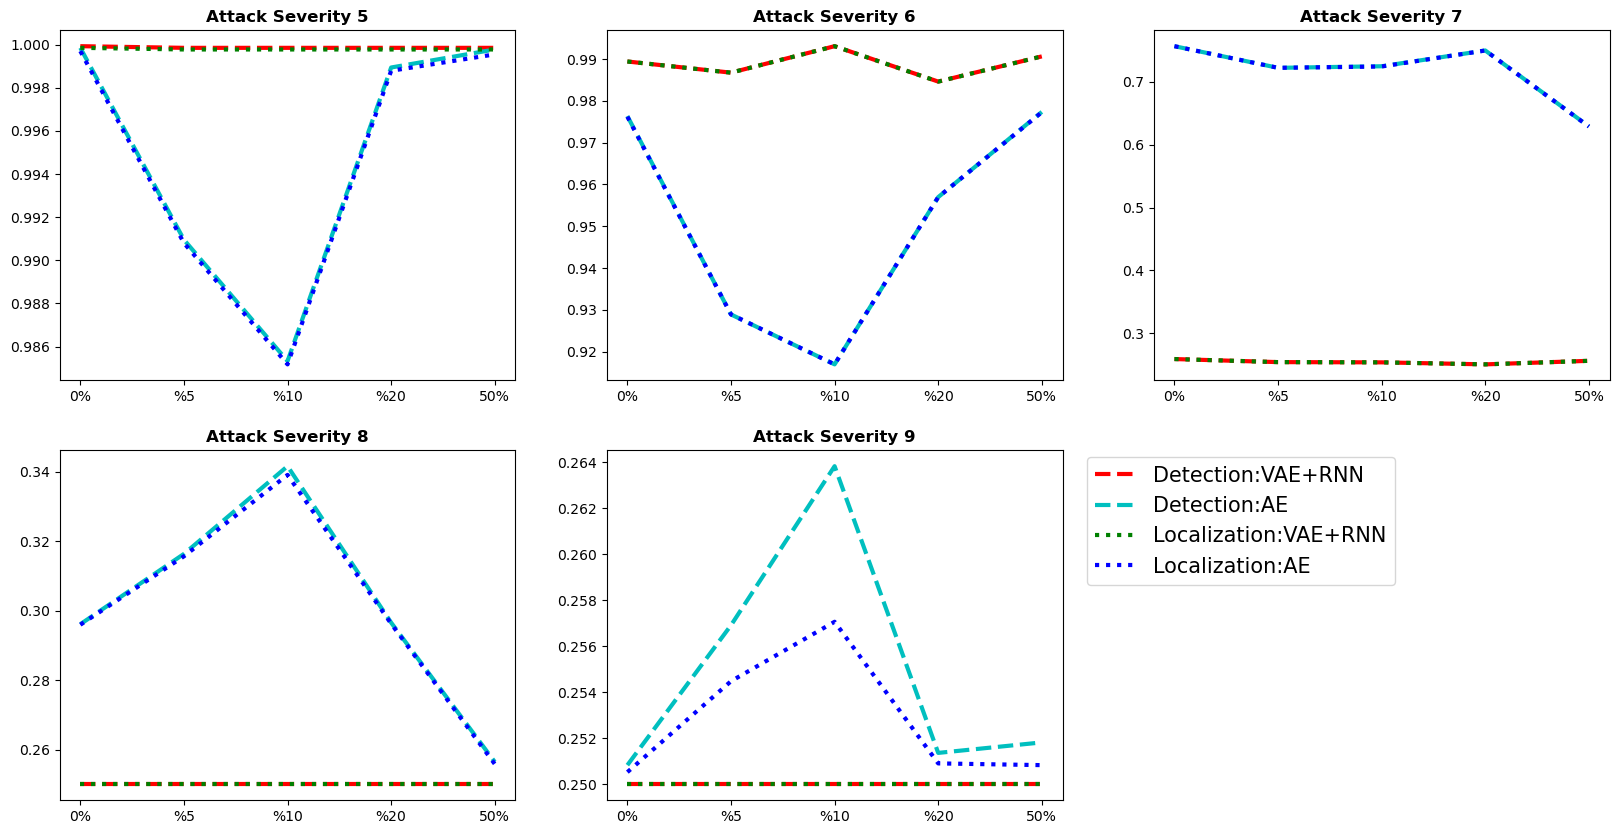

In [62]:
severity = list(range(5,10))
x = np.arange(len(noise_levels))
x_ax = ['0%', '%5', '%10', '%20', '50%']
fig, ax = plt.subplots(2,3, figsize=(20,10))
fig.delaxes(ax[1,2])
for s in severity:
    i = 0 if s < 8 else 1
    j = 0 if s < 8 else 3
    ax[i,s-5-j].plot(x, detection['vae',s], label='Detection:VAE+RNN', lw=3, linestyle="dashed", color='r')
    ax[i,s-5-j].plot(x, detection['ae',s], label='Detection:AE', lw=3, linestyle='dashed', color='c')
    ax[i,s-5-j].plot(x, localization['vae',s], label='Localization:VAE+RNN', lw=3, linestyle=":", color='g')
    ax[i,s-5-j].plot(x, localization['ae',s], label='Localization:AE', lw=3, linestyle=':', color='b')
    ax[i,s-5-j].set(xticks=x, xticklabels=x_ax)
    ax[i,s-5-j].set_title(f'Attack Severity {s}', fontweight='bold')
ax[1,1].legend(prop={'size': 15}, bbox_to_anchor=(1.03, 1.01))
plt.show()